# Test: Data Scientist (Client2) - SyftBox Mode

Automated test notebook for the Data Scientist workflow with SyftBox encryption.
Run with: `jupyter execute sc_test_ds.ipynb`

In [1]:
!pip install -q --force-reinstall --no-deps $(ls -t ../../syftbox-sdk/python/target/wheels/syftbox_sdk-*arm64.whl | head -1)
!pip install -e ../../python --upgrade -q --upgrade

In [2]:
!uv pip install scikit-misc

Resolved 2 packages in 1ms                                           
Installed 1 package in 1ms                                  
 + scikit-misc==0.5.2


In [3]:
import beaver, inspect
import beaver.computation as bc
print("beaver file:", beaver.__file__)
print("computation file:", bc.__file__)
print("contains dedup logs?", "PIL hash" in inspect.getsource(bc))

beaver file: /Users/madhavajay/dev/biovault-beaver/workspace2/python/src/beaver/__init__.py
computation file: /Users/madhavajay/dev/biovault-beaver/workspace2/python/src/beaver/computation.py
contains dedup logs? False


In [4]:
import sys
from pathlib import Path

# Configuration
TIMEOUT = 120.0
USER_EMAIL = "client2@sandbox.local"
PEER_EMAIL = "client1@sandbox.local"
DATA_DIR = Path.cwd()

In [5]:
!uv pip install scanpy

Resolved 40 packages in 8ms                                          
Installed 31 packages in 162ms                              
 + anndata==0.12.6
 + array-api-compat==1.12.0
 + contourpy==1.3.3
 + cycler==0.12.1
 + donfig==0.8.1.post1
 + fonttools==4.61.0
 + google-crc32c==1.7.1
 + h5py==3.15.1
 + joblib==1.5.2
 + kiwisolver==1.4.9
 + legacy-api-wrap==1.5
 + llvmlite==0.45.1
 + matplotlib==3.10.7
 + natsort==8.4.0
 + networkx==3.6
 + numba==0.62.1
 + numcodecs==0.16.5
 + patsy==1.0.2
 + pillow==12.0.0
 + pynndescent==0.5.13
 + pyparsing==3.2.5
 + scanpy==1.11.5
 + scikit-learn==1.7.2
 + scipy==1.16.3
 + seaborn==0.13.2
 + session-info2==0.2.3
 + statsmodels==0.14.5
 + threadpoolctl==3.6.0
 + tqdm==4.67.1
 + umap-learn==0.5.9.post2
 + zarr==3.1.5


In [6]:
import scanpy as sc
import matplotlib.pyplot as plt
from beaver import Twin
import beaver

# Connect with SyftBox backend
bv = beaver.connect(
    user=USER_EMAIL,
    data_dir=DATA_DIR,
)
print(f"[DS] Connected as {bv.user}")
print(f"[DS] SyftBox enabled: {bv.syftbox_enabled}")

🔄 Auto-load replies enabled for client2@sandbox.local (polling every 2.0s)
[DS] Connected as client2@sandbox.local
[DS] SyftBox enabled: True


In [7]:
# Request a session with the data owner
print(f"[DS] Requesting session with {PEER_EMAIL}...")
session = bv.request_session(
    peer_email=PEER_EMAIL,
    message="Requesting access for single-cell analysis test"
)

print(f"[DS] Session requested: {session.session_id}")
print(f"[DS] Waiting for session acceptance...")

# Wait for session to be accepted
session.wait_for_acceptance(timeout=TIMEOUT)
print(f"[DS] ✓ Session accepted!")

[DS] Requesting session with client1@sandbox.local...
📤 Session request sent to client1@sandbox.local
   Session ID: f3c039ddb576
   Use session.wait_for_acceptance() to wait for approval
[DS] Session requested: f3c039ddb576
[DS] Waiting for session acceptance...
⏳ Waiting for client1@sandbox.local to accept session f3c039ddb576...
📁 Created session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576
✅ Session f3c039ddb576 accepted!
[DS] ✓ Session accepted!


In [8]:
# Load Twin from session - use peer_remote_vars to read DO's data
import time

print("[DS] Waiting for Twin to be published...")
patient_sc = None
deadline = time.monotonic() + TIMEOUT

while time.monotonic() < deadline:
    try:
        # peer_remote_vars reads from peer's session folder
        patient_sc = session.peer_remote_vars["patient_sc"].load(auto_accept=True)
        if patient_sc is not None:
            break
    except (KeyError, Exception):
        pass
    time.sleep(1.0)

assert patient_sc is not None, "Failed to load Twin"
assert hasattr(patient_sc, 'public'), "Twin has no public attribute"
print(f"[DS] Loaded Twin: {patient_sc}")
print(f"[DS] Public data: {patient_sc.public.n_obs} cells")

[DS] Waiting for Twin to be published...
⏳ Waiting for artifact file to sync: patient_sc_public.bin
⠧ syncing patient_sc_public.bin (989,936,086 bytes)
✓ Artifact file synced: patient_sc_public.bin (989,936,086 bytes)
✓ Loaded Twin 'patient_sc' from published location
[DS] Loaded Twin: 🌍 Twin: patient_sc (MOCK DATA - SAFE)
  🔒 Private    (not available) 💡 .request_private()
  🌍 Public    <AnnData (preview): AnnData n_obs=30000, n_vars=36601 — r...    ← .value uses this
  Owner: client1@sandbox.local
  Live: ⚫ Disabled
  IDs: twin=81ce577a... private=8045d15d... public=d22ed1a7...
[DS] Public data: 30000 cells


## Step 1: Violin Plot

In [9]:
session.peer_remote_vars

Name,Type,ID
patient_sc,"Twin[AnnData] (30000, 36601)",52fa066ed32c...


In [10]:
patient_sc

🌍 Twin: patient_sc (MOCK DATA - SAFE)
  🔒 Private    (not available) 💡 .request_private()
  🌍 Public    <AnnData (preview): AnnData n_obs=30000, n_vars=36601 — r...    ← .value uses this
  Owner: client1@sandbox.local
  Live: ⚫ Disabled
  IDs: twin=81ce577a... private=8045d15d... public=d22ed1a7...

In [11]:
print("[DS] Running violin plot analysis...")

@bv
def make_violin(adata):
    print("n_cells:", adata.n_obs)
    sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], size=0, multi_panel=True)
    return plt.gcf()

violin_result = make_violin(patient_sc)

assert violin_result is not None, "Violin computation returned None"
assert hasattr(violin_result, 'public'), "Result has no public attribute"
print(f"[DS] Violin public stdout: {violin_result.public_stdout}")

[DS] Running violin plot analysis...
[DS] Violin public stdout: n_cells: 30000



In [14]:
violin_result

⚠️  Twin: make_violin_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━...    ← .value uses this
  🌍 Public    <Figure size 1511.11x500 with 3 Axes>    ✓
  Live: ⚫ Disabled
  📤 Captured stdout: 15 chars
  📊 Captured figures: 1
  IDs: twin=e6fe738a... private=afc8ff48... public=6f0a0438...
  💡 Access: .public_stdout, .public_stderr, .public_figures

📊 Public figures (1):


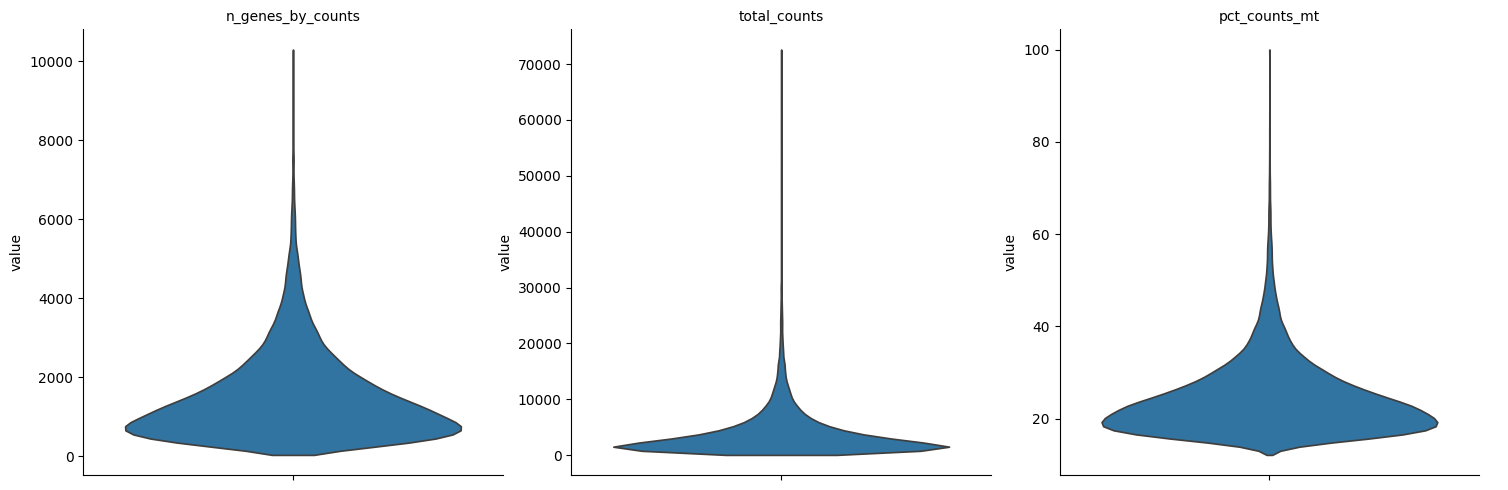

In [19]:
# Display captured figures for mock run
violin_result.show_figures('public')

In [20]:
print("[DS] Requesting private execution...")
violin_result.request_private()

[DS] Requesting private execution...
📨 Sending computation request to client1@sandbox.local
   Function: make_violin
   Result: violin_result
📤 Writing to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576/b91d65e4462f462694d2145d3e48b78a.beaver
💡 Result will auto-update when client1@sandbox.local approves


In [21]:
print("[DS] Waiting for violin result...")
env, _ = bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)
assert env is not None, "Timeout waiting for violin result"

assert violin_result.private is not None, "Private result not received"
print(f"[DS] ✓ Violin private result received")
if violin_result.private_stdout:
    print(f"[DS] Private stdout: {violin_result.private_stdout[:50]}...")

[DS] Waiting for violin result...
📬 New message: make_violin_result
   From: client1@sandbox.local
[DS] ✓ Violin private result received


In [22]:
bv.inbox()[0].load()

🔄 Twin merge updating private (dst_id=e6fe738a5101..., src_id=e6fe738a5101..., dst_private=CapturedFigure, src_private=CapturedFigure, placeholder=False, reason=idempotent_reload)
✓ Loaded 'make_violin_result' into globals


🔒 Twin: make_violin_result (REAL DATA - SENSITIVE)
  🔒 Private    <CapturedFigure png=57797 bytes, figure=no>    ← .value uses this
  🌍 Public    (not set)
  Live: ⚫ Disabled
  IDs: twin=e6fe738a... private=af243455... public=8dd56e43...

📊 Public figures (1):


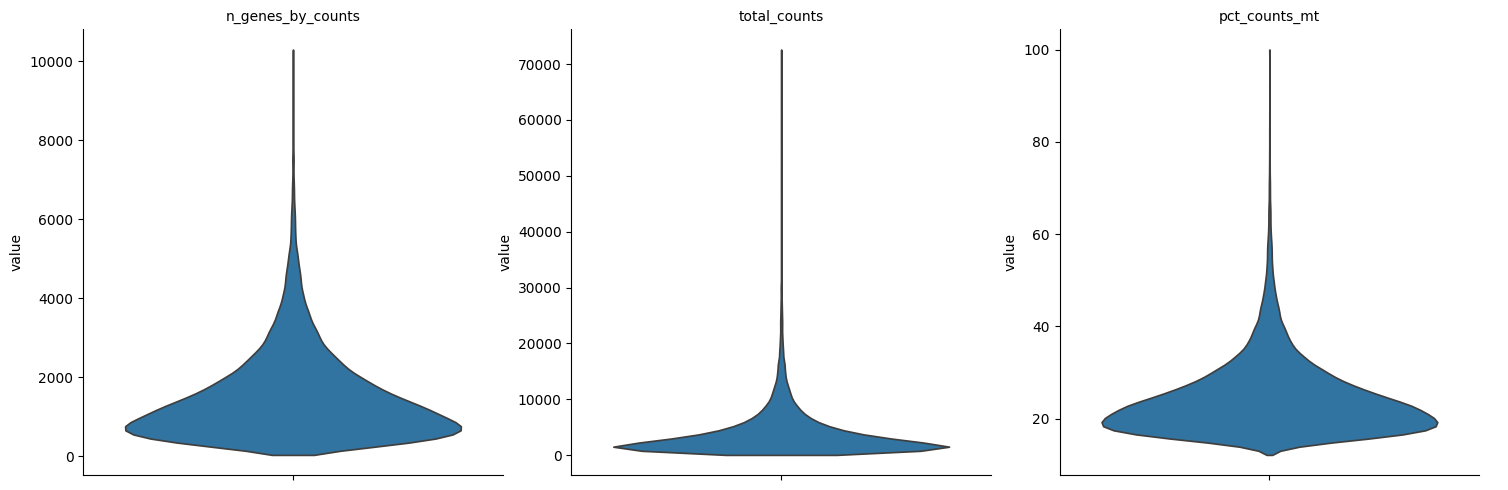

📊 Private figures (1):


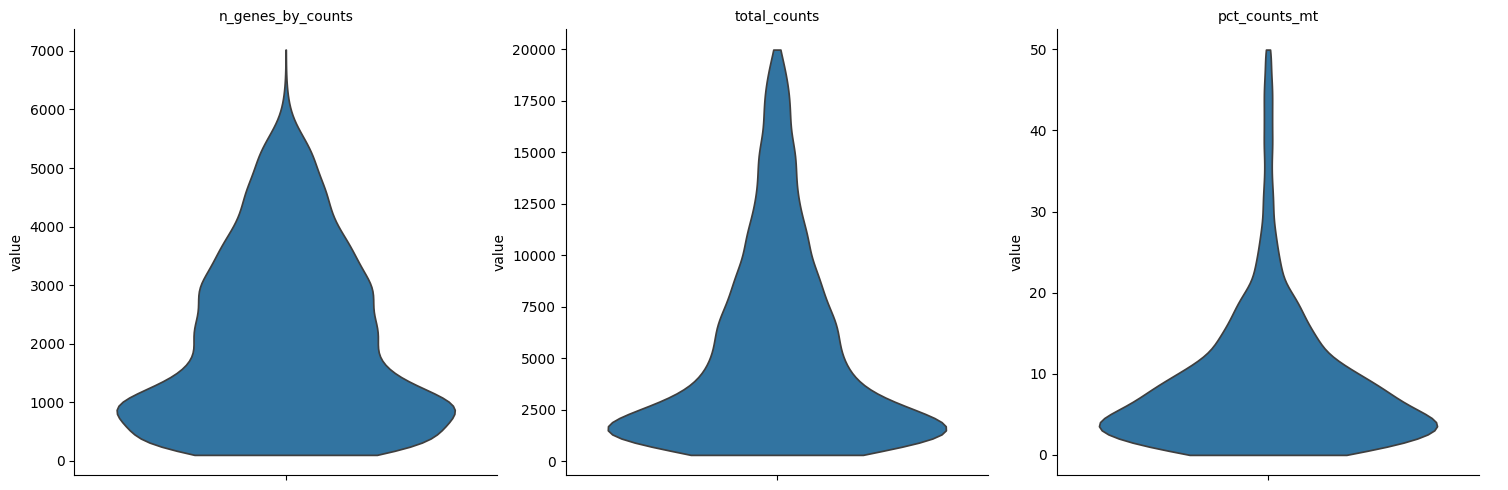

In [23]:
violin_result.show_figures("both")

## Step 2: Embedding Plot

In [24]:
print("[DS] Running embedding analysis...")

@bv
def show_embedding(adata):
    print("n_cells:", adata.n_obs)
    return sc.pl.embedding(
        adata,
        basis='X_umap',
        color=['pct_counts_mt', 'cell_type'],
        ncols=1, size=15,
        frameon=False,
        show=False
    )

embedding_result = show_embedding(patient_sc)

assert embedding_result is not None, "Embedding computation returned None"
print(f"[DS] Embedding public figures: {len(embedding_result.public_figures)}")

[DS] Running embedding analysis...
[DS] Embedding public figures: 1


In [25]:
print("[DS] Requesting private execution...")
embedding_result.request_private()

print("[DS] Waiting for embedding result...")
env, _ = bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)
assert env is not None, "Timeout waiting for embedding result"

print(f"[DS] ✓ Embedding private result received")

[DS] Requesting private execution...
📨 Sending computation request to client1@sandbox.local
   Function: show_embedding
   Result: embedding_result
📤 Writing to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576/4493b663d0d54d3c89136508fb4fc96d.beaver
💡 Result will auto-update when client1@sandbox.local approves
[DS] Waiting for embedding result...
📬 New message: show_embedding_result
   From: client1@sandbox.local
[DS] ✓ Embedding private result received


## Step 3: PCA Variance

In [26]:
print("[DS] Running PCA variance analysis...")

@bv
def plot_pca_variance(adata):
    adata.layers['raw_counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='raw_counts', n_top_genes=5000)
    sc.pp.pca(adata, use_highly_variable=True)
    with plt.rc_context({'figure.figsize': (4, 3)}):
        sc.pl.pca_variance_ratio(adata, n_pcs=50)

pca_result = plot_pca_variance(patient_sc)

assert pca_result is not None, "PCA computation returned None"
print(f"[DS] PCA public figures: {len(pca_result.public_figures)}")

[DS] Running PCA variance analysis...
[DS] PCA public figures: 1


In [27]:
print("[DS] Requesting private execution...")
pca_result.request_private()

print("[DS] Waiting for PCA result...")
env, _ = bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)
assert env is not None, "Timeout waiting for PCA result"

print(f"[DS] ✓ PCA private result received")

[DS] Requesting private execution...
📨 Sending computation request to client1@sandbox.local
   Function: plot_pca_variance
   Result: pca_result
📤 Writing to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576/eb038704f0f14715a59a03261dd3da10.beaver
💡 Result will auto-update when client1@sandbox.local approves
[DS] Waiting for PCA result...
📬 New message: plot_pca_variance_result
   From: client1@sandbox.local
[DS] ✓ PCA private result received


## Step 4: UMAP Embedding

In [28]:
print("[DS] Running UMAP embedding analysis...")

@bv
def umap_embedding(adata):
    sc.pp.neighbors(adata, n_pcs=50)
    sc.tl.umap(adata)
    return sc.pl.embedding(
        adata,
        basis='X_umap',
        color=['cell_type'],
        ncols=1, size=15,
        frameon=False,
        show=True
    )

umap_result = umap_embedding(patient_sc)

assert umap_result is not None, "UMAP computation returned None"
print(f"[DS] UMAP public figures: {len(umap_result.public_figures)}")

[DS] Running UMAP embedding analysis...
[DS] UMAP public figures: 1


In [29]:
print("[DS] Requesting private execution...")
umap_result.request_private()

print("[DS] Waiting for UMAP result...")
env, _ = bv.wait_for_message(timeout=TIMEOUT, poll_interval=1.0)
assert env is not None, "Timeout waiting for UMAP result"

print(f"[DS] ✓ UMAP private result received")

[DS] Requesting private execution...
📨 Sending computation request to client1@sandbox.local
   Function: umap_embedding
   Result: umap_result
📤 Writing to session folder: /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace2/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/f3c039ddb576/d62a5e55a9fe4f87a01c3503053b27ff.beaver
💡 Result will auto-update when client1@sandbox.local approves
[DS] Waiting for UMAP result...
📬 New message: umap_embedding_result
   From: client1@sandbox.local
[DS] ✓ UMAP private result received


In [30]:
# Final verification
print("\n" + "="*50)
print("[DS] TEST PASSED")
print("[DS] Successfully completed all 4 analysis steps:")
print("  1. Violin plot")
print("  2. Embedding plot")
print("  3. PCA variance")
print("  4. UMAP embedding")
print("="*50)

# Verify inbox has all results
inbox = bv.inbox()
print(f"\n[DS] Inbox contains {len(inbox)} messages")
assert len(inbox) >= 4, f"Expected at least 4 results in inbox, got {len(inbox)}"


[DS] TEST PASSED
[DS] Successfully completed all 4 analysis steps:
  1. Violin plot
  2. Embedding plot
  3. PCA variance
  4. UMAP embedding

[DS] Inbox contains 4 messages
